**Notebook Overview**

This notebook uses the Riskthinking.AI Python SDK to automatically pull asset‐level climate metrics and fine‐grained hazard impacts for a given company and its competitor. In the Data Import & Preprocessing section, we:

1. **Authenticate and connect to the API** using your `RISKTHINKING_API_KEY`.  
2. **Fetch aggregated climate scores** and detailed hazard‐impact outputs for each asset, horizon, and scenario pathway.  
3. **Merge these score tables with asset metadata**, then impute any missing building footprints based on type/horizon/pathway group averages.  
4. **Compute type‐level statistics** (e.g., normalized footprint and count by asset category) to support later weighting.

Once the data are preprocessed, the Analysis section illustrates how to:

- **Visualize geographic distributions** of assets and their risk metrics by country.  
- **Compare asset‐type breakdowns** between your company and a competitor.  
- **Identify high‐materiality assets** (scored by metric × footprint) on a map.  
- **Plot overall risk distributions** (boxplots and bar charts) to directly compare portfolio‐level risk.  
- **Aggregate and compare country‐level risk** using a footprint‐weighted average of the chosen metric.  

Update the “User Inputs” cell at the top with your company/competitor names, desired horizon, pathway, and metric names to rerun the full analysis end‐to‐end.


# Data Import & Preprocessing

## Initial Setup

In [ ]:
# Install dependencies (run this once if needed)
%pip install velo-sdk matplotlib polars python-dotenv pyarrow contextily geopandas seaborn plotly --quiet

# Note: After installing new packages, you may need to restart the kernel before running the rest of the notebook.

Note: you may need to restart the kernel to use updated packages.


In [52]:
# Imports (all top-level imports in one place)
import os
from typing import List

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
import plotly.express as px
import plotly.io as pio
import contextily as ctx
import geopandas as gpd

# Velo (Riskthinking) SDK for API access
from velo_sdk.api import APIClient

# Dotenv for loading local .env file
from dotenv import load_dotenv

import warnings
     

## User Inputs

In [54]:
# ────────────────────────────────────────────────────────────────────────────────
# User-defined variables (change these as needed)
# ────────────────────────────────────────────────────────────────────────────────

# Enter company names. Ensure the competitor name is entered as accurately as possible.
COMPANY_NAME = 'Procter & Gamble'
COMPETITOR_NAME = 'Unilever PLC'

""" 
Specify the following parameters for importing climate risk data:

horizons: 2025 to 2100 in steps of 5. See Data Coverage section of documentation for full list of values.
Multiple horizons may be selected in a list format, for example, [2025, 2040, 2050]. 
However, this notebook is designed to analyze a single horizon

pathway: String specifying the scenario pathway. See Data Coverage section of documentation for full list 
of string values.

metric: String specifying aggregated asset-level metric to import. See Data Coverage section of documentation 
for full list of string values. Multiple metrics may be selected in a list format containing a single 
comma-separated string, for example, ["dcr_score,expected_impact"]. However, this notebook is designed to 
analyze a single aggregate metric. Leave blank in the function call to import all available metrics.
"""
METRIC = ['expected_impact']
HORIZON = [2030]
PATHWAY = 'SV'

# Plot styling
plt.style.use('seaborn-whitegrid')
sns.set_context('notebook', font_scale=1.1)
pio.renderers.default = 'svg'
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Define Functions

In [55]:
# ────────────────────────────────────────────────────────────────────────────────
# Merge asset info dataframe with asset impact dataframe.
# ────────────────────────────────────────────────────────────────────────────────
def fetch_asset_scores(
    company_id: str, horizons: List[int], pathway: str, metric: List[str]
) -> pl.DataFrame:
    """
    Fetch risk/impact scores for a company from the API.

    Parameters
    ----------
    company_id : str
        Company ID previously extracted using the "search_companies" method.
    horizons : List[str]
        A list of integer horizons (e.g., [2025, 2030, 2040]). In practice, this notebook
        uses a single integer in the list.
    pathway : str
        Emissions pathway (e.g., 'SV').
    metric: List[str]
        asset-level aggregate metric (e.g., ['expected_impact']). In practice, this notebook
        uses a single string in the list.

    Returns
    -------
    pl.DataFrame
        Polars DataFrame containing climate impact scores for all company assets.
    """

    company_score_pl = pl.DataFrame()
    for horizon in horizons:
        iterator = client.companies.list_company_asset_climate_scores(
            company_id=company_id, horizon=horizon, pathway=pathway, metric=metric
        )

        data = list(iterator)

        if data:
            pl_chunk = pl.DataFrame(data).with_columns(
                [pl.lit(horizon).alias('horizon'), pl.lit(pathway).alias('pathway')]
            )
            company_score_pl = company_score_pl.vstack(pl_chunk)

        return company_score_pl


# ────────────────────────────────────────────────────────────────────────────
# Fetch impact scores for each asset via the API, filtered by horizon/pathway.
# ────────────────────────────────────────────────────────────────────────────
def fetch_asset_impact_scores(
    company_id: str, horizons: List[int], pathway: str
) -> pl.DataFrame:
    """
    Retrieve and flatten per-asset, per-hazard impact scores for a given company.

    This function calls `client.companies.list_company_asset_impact_scores()` for each
    horizon in `horizons`, adds the horizon/pathway columns, and then explodes the
    'index_risks' struct into individual columns.

    Parameters
    ----------
    company_id : str
        The unique identifier for the company whose assets' impact scores are being fetched.
    horizons : List[int]
        A list of integer horizons (e.g., [2025, 2030, 2040]). In practice, this notebook
        uses a single integer in the list.
    pathway : str
        The scenario pathway string (e.g., "SV").

    Returns
    -------
    pl.DataFrame
        A Polars DataFrame containing:
        - asset_id (and other top-level fields returned by the API)
        - horizon (int)
        - pathway (str)
        - All fields from each exploded 'index_risks' struct, one row per hazard index.
    """
    impact_pl = pl.DataFrame()

    for horizon in horizons:
        iterator = client.companies.list_company_asset_impact_scores(
            company_id=company_id,
            horizon=horizon,
            pathway=pathway,
        )
        data = list(iterator)
        if data:
            df_chunk = pl.DataFrame(data).with_columns(
                [pl.lit(horizon).alias('horizon'), pl.lit(pathway).alias('pathway')]
            )
            impact_pl = impact_pl.vstack(df_chunk)

    if impact_pl.is_empty():
        return impact_pl

    # Explode 'index_risks' and expand struct fields into separate columns
    impact_pl = impact_pl.explode('index_risks').unnest('index_risks')

    return impact_pl


# ──────────────────────────────────────────────
# Merges asset‐level scores with asset metadata.
# ──────────────────────────────────────────────
def merge_scores_assets(
    scores_df: pl.DataFrame, assets_df: pl.DataFrame
) -> pl.DataFrame:
    """
    Join scores_df (impact scores) with assets_df (asset metadata) on asset_id → id.
    Drops redundant columns (with suffix “_right”).

    Parameters
    ----------
    scores_df : pl.DataFrame
        A Polars DataFrame containing asset impact scores; must have column 'asset_id'.
    assets_df : pl.DataFrame
        A Polars DataFrame containing asset metadata; must have column 'id'.

    Returns
    -------
    pl.DataFrame
        Merged DataFrame with impact scores and asset metadata combined.
    """
    return scores_df.join(
        assets_df, left_on='asset_id', right_on='id', how='left'
    ).drop(
        [
            'asset_type_right',
            'city_right',
            'state_right',
            'country_right',
            'address_right',
        ]
    )


# ──────────────────────────────────────────────────────────────────────────────────────
# Impute missing building footprints based on average within horizon/pathway/asset_type.
# ──────────────────────────────────────────────────────────────────────────────────────
def impute_building_footprint(df: pl.DataFrame) -> pl.DataFrame:
    """
    Where 'building_footprint' is null or zero, impute with the average footprint for
    that combination of horizon/pathway/asset_type.

    Parameters
    ----------
    df : pl.DataFrame
        Must contain columns ['horizon', 'pathway', 'asset_type', 'building_footprint'].

    Returns
    -------
    pl.DataFrame
        Updated DataFrame with missing footprints filled in, and original column replaced.
    """

    grp_means = (
        df.lazy()
        .group_by(['horizon', 'pathway', 'asset_type'])
        .agg(pl.col('building_footprint').mean().alias('building_footprint_mean'))
        .collect()
    )

    df = df.join(grp_means, on=['horizon', 'pathway', 'asset_type'], how='left')

    df = df.with_columns(
        pl.when(pl.col('building_footprint') == 0)
        .then(pl.col('building_footprint_mean'))
        .otherwise(pl.col('building_footprint'))
        .alias('building_footprint_2')
    ).with_columns(pl.col('building_footprint_2').fill_null(700))

    return df.drop('building_footprint_mean')


# ────────────────────────────────────────────────────────────────────────────────
# Compute country-level risk aggregates.
# ────────────────────────────────────────────────────────────────────────────────
def compute_country_risk(
    df: pl.DataFrame,
    company_label: str,
    metric: List[str],
    type_stats: pl.DataFrame,
    alpha: float = 0.2,
) -> pl.DataFrame:
    """
    Computes country-level risk for a given DataFrame `df` and company label,
    using the user-selected asset-level aggregate metric (metric[0]) weighted by
    normalized asset footprint and asset materiality score.

    The parameter alpha can be adjusted from 0 to 1 to specify relative weighting of
    normalized asset footprint vs asset materiality score.

    Footprint is normalized using a min-max scaling of all assets of the relevant
    asset type in that country, belonging to both the companies specified by
    company_name and competitor_name

    Parameters
    ----------
    full_df : pl.DataFrame
        Must contain columns ['country', 'asset_type', 'building_footprint', <METRIC>].
    company_label : str
        Label of the company to annotate the results.
    metric : List[str]
        Asset-level aggregate metric (e.g., ['expected_impact']). In practice, this notebook
        uses a single string in the list.
    type_stats: pl.DataFrame
        Helper dataframe for grouping
    alpha: float
        Relative weighting of normalized asset footprint vs asset materiality score.

    Returns
    -------
    pl.DataFrame
        DataFrame grouped by country with columns:
        - country
        - total_building_footprint
        - avg_metric (weighted by footprint)
        - company (constant string)
    """
    m = metric[0]  # e.g. "expected_impact"

    lf = df.join(type_stats, on=['country', 'asset_type'], how='left').lazy()

    # normalize within country & asset_type
    lf = lf.with_columns(
        [
            pl.when(pl.col('ft_max_cty_type') != pl.col('ft_min_cty_type'))
            .then(
                (pl.col('building_footprint_2') - pl.col('ft_min_cty_type'))
                / (pl.col('ft_max_cty_type') - pl.col('ft_min_cty_type'))
            )
            .otherwise(1.0)
            .alias('norm_fp_cty_type'),
            (pl.col('materiality_score') / 100).alias('norm_mat'),
        ]
    )

    # composite size importance
    lf = lf.with_columns(
        (alpha * pl.col('norm_fp_cty_type') + (1 - alpha) * pl.col('norm_mat')).alias(
            'size_imp'
        )
    )

    # asset‐level risk from the chosen metric
    lf = lf.with_columns((pl.col(m) * pl.col('size_imp')).alias('asset_risk'))

    # aggregate to country
    return (
        lf.group_by('country')
        .agg(
            [
                pl.sum('asset_risk').alias('country_risk'),
                pl.count('asset_id').alias('n_assets'),
            ]
        )
        .sort('country_risk', descending=True)
        .with_columns(pl.lit(company_label).alias('company'))
        .collect()
    )


## API Authentication & Client Setup

In [56]:
# ────────────────────────────────────────────────────────────────────────────────
# Authenticate with Riskthinking API (using VeloClient or local .env)
# ────────────────────────────────────────────────────────────────────────────────

try:
    # If running in Google Colab, fetch secret from userdata
    from google.colab import auth, userdata  # type: ignore

    auth.authenticate_user()
    os.environ['RISKTHINKING_API_KEY'] = userdata.get('RISKTHINKING_API_KEY')
except:
    # Not in Colab: load from local .env
    load_dotenv()  # looks for .env in working directory

# Initialize API Client
API_KEY = os.getenv('RISKTHINKING_API_KEY')
if not API_KEY:
    raise RuntimeError(
        'RISKTHINKING_API_KEY is not set. Please set it in your .env or environment.'
    )

# Instantiate the VELO SDK client (it will look for $RISKTHINKING_API_KEY automatically)
client = APIClient()

## Specify Variables & Import Data

In [57]:
# ────────────────────────────────────────────────────────────────────────────────
# Search for company and competitor by name
# ────────────────────────────────────────────────────────────────────────────────


# Search a company/competitor name string and return the top result.
# Ensure the company/competitor name is entered as accurately as possible.
# Verify accuracy of result before proceeding

company_name = 'Procter & Gamble'
company = client.companies.search_companies(name=company_name, limit=1)[0]
company_id = company.id

competitor_name = 'Unilever PLC'
competitor = client.companies.search_companies(name=competitor_name, limit=1)[0]
competitor_id = competitor.id


# Preview
print(company)
print(competitor)

id='c1f72107-9cbc-4ec6-8d40-24685b5526da' name='Procter & Gamble Company' slug='procter--gamble-company' headquarters_address='One Procter & Gamble Plaza , Cincinnati, 45202, United States' organization_id=None market_cap=369380000000 annual_revenue=80187000000 headquarters_country='US' sector='Consumer Discretionary' isin_codes=['BRPGCOBDR001', 'CA74276N1015', 'US7427181091', 'ARDEUT110335'] figi_codes=[] cik_code='' lei_code='' stock_tickers=['PGD', 'PGCL', '0NOF', 'PGP', 'PG *', 'PGCO34', 'PGm', 'PRG0', 'PRG', 'PG', '4PG'] is_grandparent=None data_generated_at=None data_generation_status=None created_at='2025-02-14T00:20:12.573287' updated_at='2025-05-23T18:38:24.305117'
id='888e3c75-5b23-45f9-b46e-9c0a94b3087e' name='Unilever PLC' slug='unilever-plc' headquarters_address='Unilever House 100 Victoria Embankment, London, EC4Y 0DY, United Kingdom' organization_id=None market_cap=115262883914 annual_revenue=62543466944 headquarters_country='GB' sector='Consumer Discretionary' isin_code

In [58]:
# ────────────────────────────────────────────────────────────────────────────────
# Import company and competitor asset data
# ────────────────────────────────────────────────────────────────────────────────

company_assets_pl = pl.DataFrame(
    client.companies.list_company_assets(company_id=company_id)
)
competitor_assets_pl = pl.DataFrame(
    client.companies.list_company_assets(company_id=competitor_id)
)

# Preview
print(company_assets_pl.head(3))
print(competitor_assets_pl.head(3))

shape: (3, 16)
┌─────────────┬──────┬────────────┬────────┬───┬────────────┬────────────┬────────────┬────────────┐
│ id          ┆ name ┆ asset_type ┆ city   ┆ … ┆ ipcc_regio ┆ materialit ┆ created_at ┆ updated_at │
│ ---         ┆ ---  ┆ ---        ┆ ---    ┆   ┆ n          ┆ y_score    ┆ ---        ┆ ---        │
│ str         ┆ str  ┆ str        ┆ str    ┆   ┆ ---        ┆ ---        ┆ str        ┆ str        │
│             ┆      ┆            ┆        ┆   ┆ str        ┆ f64        ┆            ┆            │
╞═════════════╪══════╪════════════╪════════╪═══╪════════════╪════════════╪════════════╪════════════╡
│ 00be1500-9f ┆      ┆ Profession ┆ Ibadan ┆ … ┆ Western-Af ┆ 5.0        ┆ 2025-02-14 ┆ 2025-05-23 │
│ 6c-45c2-809 ┆      ┆ al         ┆ South  ┆   ┆ rica       ┆            ┆ T00:32:07. ┆ T18:42:12. │
│ c-bae010…   ┆      ┆ Services   ┆ West   ┆   ┆            ┆            ┆ 718402     ┆ 529616     │
│ 04f676bb-2f ┆      ┆ Management ┆ Boston ┆ … ┆ E.North-Am ┆ 5.0        ┆ 2

## Fetch Aggregate Climate Scores for Assets

In [59]:
# ─────────────────────────────────────────────────────────────────────────────
# Fetch climate scores for each asset via the API, filtered by horizon/pathway.
# ─────────────────────────────────────────────────────────────────────────────

# Fetch for company
company_score_pl = fetch_asset_scores(company.id, HORIZON, PATHWAY, METRIC)

# Fetch for competitor
competitor_score_pl = fetch_asset_scores(competitor.id, HORIZON, PATHWAY, METRIC)

## Fetch Impact Data

In [60]:
# ────────────────────────────────────────────────────────────────────────────
# Fetch impact scores for each asset via the API, filtered by horizon/pathway.
# ────────────────────────────────────────────────────────────────────────────

company_impact_pl = fetch_asset_impact_scores(
    company_id=company.id, horizons=HORIZON, pathway=PATHWAY
)


competitor_impact_pl = fetch_asset_impact_scores(
    company_id=competitor.id, horizons=HORIZON, pathway=PATHWAY
)

# Preview
print(company_impact_pl.head(3))
print(competitor_impact_pl.head(3))

shape: (3, 18)
┌────────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬─────────┬─────────┐
│ asset_id   ┆ index_name ┆ index_impa ┆ index_imp ┆ … ┆ index_att ┆ index_att ┆ horizon ┆ pathway │
│ ---        ┆ ---        ┆ ct_cvar_50 ┆ act_cvar_ ┆   ┆ ribution_ ┆ ribution_ ┆ ---     ┆ ---     │
│ str        ┆ str        ┆ ---        ┆ 95        ┆   ┆ cvar_95   ┆ cvar_50   ┆ i32     ┆ str     │
│            ┆            ┆ f64        ┆ ---       ┆   ┆ ---       ┆ ---       ┆         ┆         │
│            ┆            ┆            ┆ f64       ┆   ┆ f64       ┆ f64       ┆         ┆         │
╞════════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═════════╪═════════╡
│ 743bc81b-e ┆ dlyfrzthw  ┆ 0.002427   ┆ 0.007504  ┆ … ┆ 0.395592  ┆ 0.232145  ┆ 2030    ┆ SV      │
│ f2f-4070-8 ┆            ┆            ┆           ┆   ┆           ┆           ┆         ┆         │
│ 983-169243 ┆            ┆            ┆           ┆   ┆           ┆        

## Merge, Impute footprints, and Compute Country‐Level Risks

In [61]:
# ────────────────────────────────────────────────────────────────────────────────
# This code block:
# 1. Merges asset‐level scores with asset metadata for both company and competitor.
# 2. Imputes missing or zero footprints.
# 3. Tags each row with the respective company name.
# 4. Computes type‐level statistics (type_stats) across all assets.
# 5. Calls compute_country_risk(...) for both company and competitor using:
#    - full DataFrame per entity
#    - chosen METRIC (a list of one string)
#    - shared type_stats DataFrame
#    - alpha for weighting between footprint and materiality
# 6. Prints the top rows of each country‐level risk result.
# ────────────────────────────────────────────────────────────────────────────────

# Merge asset scores with asset metadata
company_full_pl = merge_scores_assets(company_score_pl, company_assets_pl)
competitor_full_pl = merge_scores_assets(competitor_score_pl, competitor_assets_pl)

# Impute missing or zero building footprints
company_full_pl = impute_building_footprint(company_full_pl)
competitor_full_pl = impute_building_footprint(competitor_full_pl)

# Annotate each DataFrame with the company/competitor label
company_full_pl = company_full_pl.with_columns(pl.lit(company_name).alias('company'))
competitor_full_pl = competitor_full_pl.with_columns(
    pl.lit(competitor_name).alias('company')
)

# Compute type‐level statistics across combined assets of both entities
#    type_stats includes, for each asset_type:
#      - total_footprint_by_type: sum of building_footprint across that type
#      - count_by_type: number of assets of that type
#      - normalized_fp: total_footprint_by_type divided by overall total footprint
#      - normalized_count: count_by_type divided by overall total asset count
combined_full_pl = pl.concat([company_full_pl, competitor_full_pl])
type_stats = (
    combined_full_pl.lazy()
    .group_by(['country', 'asset_type'])
    .agg(
        [
            pl.col('building_footprint_2').min().alias('ft_min_cty_type'),
            pl.col('building_footprint_2').max().alias('ft_max_cty_type'),
        ]
    )
    .collect()
)

# Compute country‐level risk for the company
company_country_risk = compute_country_risk(
    company_full_pl, company_name, METRIC, type_stats, alpha=0.2
)
competitor_country_risk = compute_country_risk(
    competitor_full_pl, competitor_name, METRIC, type_stats, alpha=0.2
)

print('Company country-level risk (top 5 rows):')
print(company_country_risk.head())

print('\nCompetitor country-level risk (top 5 rows):')
print(competitor_country_risk.head())


Company country-level risk (top 5 rows):
shape: (5, 4)
┌─────────┬──────────────┬──────────┬──────────────────┐
│ country ┆ country_risk ┆ n_assets ┆ company          │
│ ---     ┆ ---          ┆ ---      ┆ ---              │
│ str     ┆ f64          ┆ u32      ┆ str              │
╞═════════╪══════════════╪══════════╪══════════════════╡
│ USA     ┆ 2.599128     ┆ 37       ┆ Procter & Gamble │
│ IND     ┆ 0.939964     ┆ 14       ┆ Procter & Gamble │
│ CHN     ┆ 0.464025     ┆ 3        ┆ Procter & Gamble │
│ THA     ┆ 0.10811      ┆ 1        ┆ Procter & Gamble │
│ BRA     ┆ 0.092241     ┆ 3        ┆ Procter & Gamble │
└─────────┴──────────────┴──────────┴──────────────────┘

Competitor country-level risk (top 5 rows):
shape: (5, 4)
┌─────────┬──────────────┬──────────┬──────────────┐
│ country ┆ country_risk ┆ n_assets ┆ company      │
│ ---     ┆ ---          ┆ ---      ┆ ---          │
│ str     ┆ f64          ┆ u32      ┆ str          │
╞═════════╪══════════════╪══════════╪══════════

In [62]:
# ─────────────────────────────────────
# Prepare combined counts for filtering
# ─────────────────────────────────────

# Combined asset counts by country and asset_type
country_counts_combined = (
    pd.concat(
        [
            company_full_pl.to_pandas()[['country', 'asset_id']],
            competitor_full_pl.to_pandas()[['country', 'asset_id']],
        ]
    )
    .groupby('country')['asset_id']
    .nunique()
    .nlargest(40)
    .index.tolist()
)
asset_counts_combined = (
    pd.concat(
        [
            company_full_pl.to_pandas()[['asset_type', 'asset_id']],
            competitor_full_pl.to_pandas()[['asset_type', 'asset_id']],
        ]
    )
    .groupby('asset_type')['asset_id']
    .nunique()
    .nlargest(8)
    .index.tolist()
)
# Combined risk by country
risk_df_combined = pd.concat(
    [
        company_country_risk.to_pandas()[['country', 'country_risk']],
        competitor_country_risk.to_pandas()[['country', 'country_risk']],
    ]
)
risk_top25 = (
    risk_df_combined.groupby('country')['country_risk']
    .sum()
    .nlargest(25)
    .index.tolist()
)

# Analysis

## 1. Geographic Distribution of assets by country

In [63]:
color_map = {
    company_name: '#7C6992',  # for the primary company
    competitor_name: '#ED8B00',  # for the competitor
}

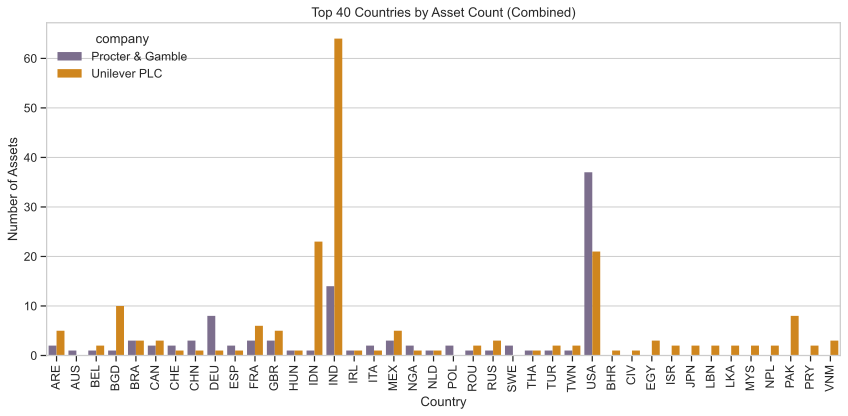

In [64]:
# ─────────────────────────────────────────────────────────────────────────────────
# Plot the number of assets per country for each company
# Limited to top 40 countries by total combined number of assets for both companies
# ─────────────────────────────────────────────────────────────────────────────────

fig = plt.figure(figsize=(12, 6))
data_cc = []
for df, name in [
    (company_full_pl, company_name),
    (competitor_full_pl, competitor_name),
]:
    df_pd = df.to_pandas()
    df_pd = df_pd[df_pd['country'].isin(country_counts_combined)]
    cc = df_pd.groupby('country')['asset_id'].nunique().reset_index(name='count')
    cc['company'] = name
    data_cc.append(cc)
cc_df = pd.concat(data_cc, ignore_index=True)
sns.barplot(data=cc_df, x='country', y='count', hue='company', palette=color_map)
plt.xticks(rotation=90)
plt.title('Top 40 Countries by Asset Count (Combined)')
plt.xlabel('Country')
plt.ylabel('Number of Assets')
plt.tight_layout()
plt.show()


## 2. Asset type distribution

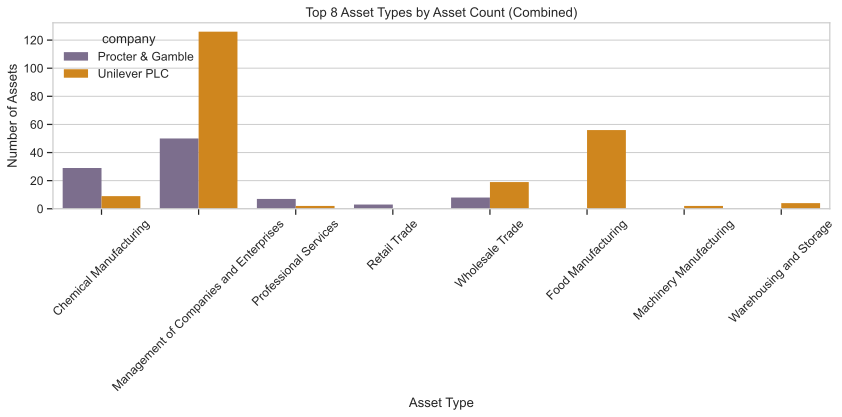

In [65]:
# ──────────────────────────────────────────────────────────────────────────────────
# Plot the number of assets per asset type for each company
# Limited to top 8 asset types by total combined number of assets for both companies
# ──────────────────────────────────────────────────────────────────────────────────

plt.figure(figsize=(12, 6))
data_at = []
for df, name in [
    (company_full_pl, company_name),
    (competitor_full_pl, competitor_name),
]:
    df_pd = df.to_pandas()
    df_pd = df_pd[df_pd['asset_type'].isin(asset_counts_combined)]
    at = df_pd.groupby('asset_type')['asset_id'].nunique().reset_index(name='count')
    at['company'] = name
    data_at.append(at)
at_df = pd.concat(data_at, ignore_index=True)
sns.barplot(data=at_df, x='asset_type', y='count', hue='company', palette=color_map)
plt.xticks(rotation=45)
plt.title('Top 8 Asset Types by Asset Count (Combined)')
plt.xlabel('Asset Type')
plt.ylabel('Number of Assets')
plt.tight_layout()
plt.show()

## 3. High‐materiality asset locations with asset type

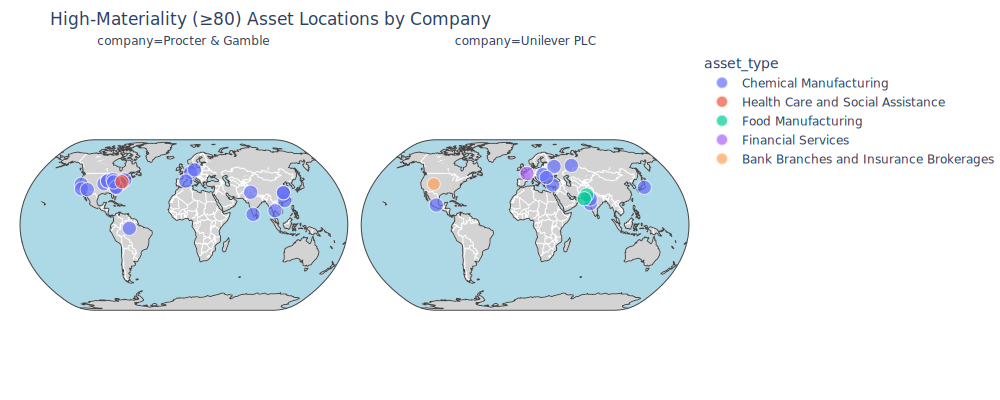

In [71]:
# ────────────────────────────────────────────────────────────────
# Plot all assets with a high materiality score for both companies
# ────────────────────────────────────────────────────────────────

# Materiality threshold for plotting
threshold = 80

map_df = (
    pl.concat(
        [
            company_full_pl.with_columns(pl.lit(company_name).alias('company')),
            competitor_full_pl.with_columns(pl.lit(competitor_name).alias('company')),
        ]
    )
    .filter(pl.col('materiality_score') >= threshold)
    .select(['latitude', 'longitude', 'asset_type', 'materiality_score', 'company'])
    .to_pandas()
)

fig = px.scatter_geo(
    map_df,
    lat='latitude',
    lon='longitude',
    color='asset_type',
    size='materiality_score',
    size_max=10,
    facet_col='company',
    projection='natural earth',
    title=f'High-Materiality (≥{threshold}) Asset Locations by Company',
    custom_data=['asset_type', 'company', 'materiality_score'],
    width=1000, 
    height=400,
)

fig.update_traces(
    hovertemplate=(
        'Asset Type: %{customdata[0]}<br>'
        'Company: %{customdata[1]}<br>'
        'Materiality Score: %{customdata[2]:.0f}'
        '<extra></extra>'
    )
)

fig.update_geos(
    showland=True,
    landcolor='LightGray',
    showocean=True,
    oceancolor='LightBlue',
    showcountries=True,
    countrycolor='White',
)
fig.update_layout(margin={'r': 0, 't': 50, 'l': 20, 'b': 0})

fig.show()

## 4. Asset-level aggregate risk comparison

/Users/shamthanekar/miniforge3/envs/cdtenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/Users/shamthanekar/miniforge3/envs/cdtenv/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



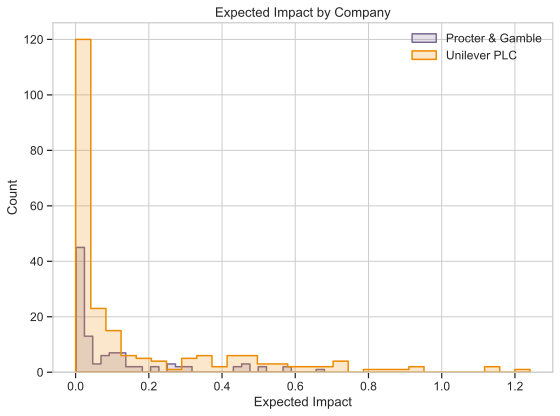

In [67]:
# ────────────────────────────────────────────────────
# Plot aggregated metric statistics for both companies
# ────────────────────────────────────────────────────

metric_selected = METRIC[0]
bins = 30

company_series = company_full_pl.select(metric_selected).to_pandas()[metric_selected]
competitor_series = competitor_full_pl.select(metric_selected).to_pandas()[
    metric_selected
]

plt.figure(figsize=(8, 6))

# Company histogram
sns.histplot(
    company_series, # type: ignore
    bins=bins,
    element='step',
    fill=True,
    alpha=0.2,
    linewidth=1.5,
    color=color_map[company_name],
    label=company_name,
)

# Competitor histogram
sns.histplot(
    competitor_series, # type: ignore
    bins=bins,
    element='step',
    fill=True,
    alpha=0.2,
    linewidth=1.5,
    color=color_map[competitor_name],
    label=competitor_name,
)

plt.title(f'{metric_selected.replace("_", " ").title()} by Company')
plt.xlabel(metric_selected.replace('_', ' ').title())
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Country level risk

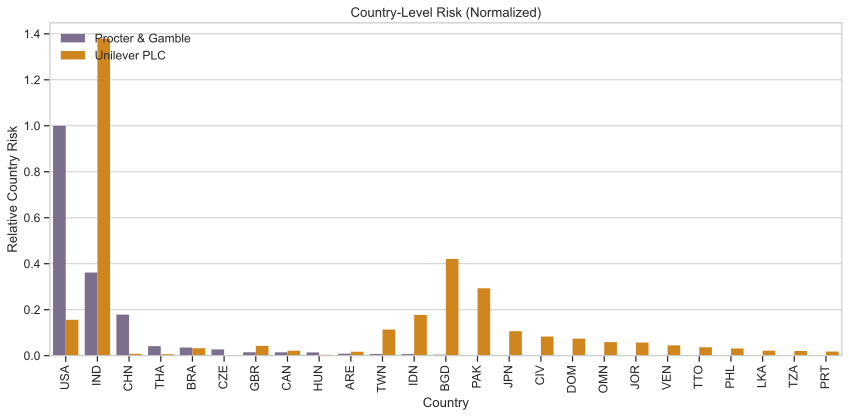

In [68]:
# ─────────────────────────────────────────────────────────────────────────────────
# Plot country-level risk for each company based on the chosen aggregate metric.
# The plotted value is the country-level risk relative to the highest value of
# country-level risk for the base company.
# The highest value of Relative Country Risk for the base company will always be 1.
# ─────────────────────────────────────────────────────────────────────────────────

base_risk_pd = company_country_risk.to_pandas()
competitor_risk_pd = competitor_country_risk.to_pandas()
max_base_risk = base_risk_pd['country_risk'].max()

risk_df = pd.concat([base_risk_pd, competitor_risk_pd], ignore_index=True)
risk_df['relative_risk'] = risk_df['country_risk'] / max_base_risk

risk_df = risk_df[risk_df['country'].isin(risk_top25)]

plt.figure(figsize=(12, 6))
sns.barplot(
    data=risk_df, x='country', y='relative_risk', hue='company', palette=color_map
)
plt.xticks(rotation=90)
plt.ylabel('Relative Country Risk')
plt.xlabel('Country')
plt.title('Country-Level Risk (Normalized)')
plt.legend(title='')
plt.tight_layout()
plt.show()

## 6. Hazard Analysis

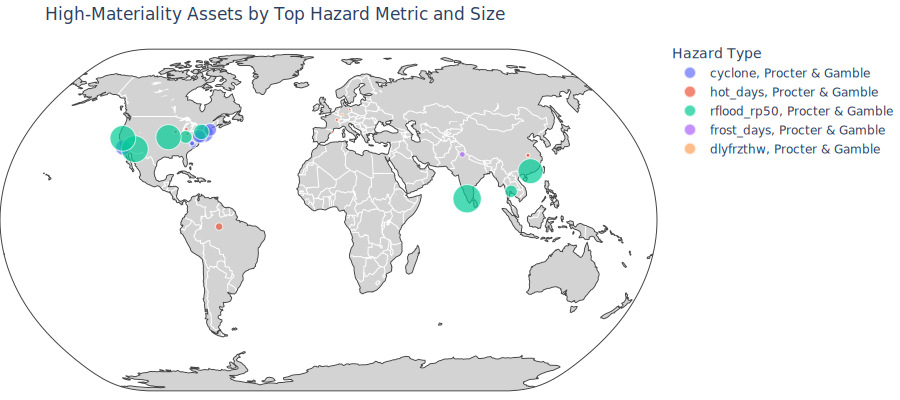

In [73]:
# ─────────────────────────────────────────────────────────────────────────────────────────────────────────────
# Plots base company assets with a high materiality score with additional hazard information.
# Marker size indicates level of aggregate risk.
# Marker colour indicates hazard type with the highest contribution to the chosen hazard_metric for that asset.
# ──────────────────────────────────────────────────────────────────────────────────────────────────────────────

# Asset-level aggregate metric selected earlier in the notebook
asset_metric = METRIC[0]

# Hazard-specific metric choices (columns starting with "index_impact_"):
hazard_metric_choices = [
    c for c in company_impact_pl.columns if c.startswith('index_impact_')
]

# Default hazard-specific metric. Change this to highlight desired metric.
hazard_metric = 'index_impact_cvar_95'

# Materiality threshold for highlighting.
# Change this to highlight assets above a defined materiality threshold.
materiality_threshold = 50

# Determine top hazard per asset based on the chosen hazard-specific metric
impact_max = (
    company_impact_pl.lazy()
    .sort(hazard_metric, descending=True)
    .group_by('asset_id')
    .agg(
        [
            pl.first('index_name').alias('top_index_name'),
            pl.first(hazard_metric).alias('top_hazard_value'),
        ]
    )
    .collect()
)

map_df = (
    company_full_pl.join(impact_max, on='asset_id', how='inner')
    .filter(pl.col('materiality_score') >= materiality_threshold)
    .select(
        [
            'latitude',
            'longitude',
            asset_metric,
            'top_index_name',
            'top_hazard_value',
            'company',
        ]
    )
    .to_pandas()
)

fig = px.scatter_geo(
    map_df,
    lat='latitude',
    lon='longitude',
    color='top_index_name',
    size=asset_metric,
    symbol='company',
    projection='natural earth',
    title='High-Materiality Assets by Top Hazard Metric and Size',
    # pass exactly the fields we want into customdata
    custom_data=[asset_metric, 'top_index_name', 'top_hazard_value'],
    width=900, 
    height=400,
)

# Build a hovertemplate: no lon/lat, just our three items
fig.update_traces(
    hovertemplate=(
        f'{asset_metric.replace("_", " ").title()}: %{{customdata[0]:.2f}}<br>'
        'Top Hazard: %{customdata[1]}<br>'
        f'{hazard_metric.replace("_", " ").title()}: %{{customdata[2]:.2f}}'
        '<extra></extra>'
    )
)

fig.update_geos(
    showland=True, landcolor='LightGray', showcountries=True, countrycolor='White'
)
fig.update_layout(
    legend_title_text='Hazard Type', margin={'l': 0, 'r': 0, 't': 40, 'b': 0}
)
fig.show()